<a href="https://colab.research.google.com/github/MoHAMDY93/test_vs/blob/master/Stroke_Prediction_using_ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset from Kaggle Rather than downloading it locally
https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fedesoriano_stroke_prediction_dataset_path = kagglehub.dataset_download('fedesoriano/stroke-prediction-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'stroke-prediction-dataset' dataset.
Data source import complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

# About Dataset

# Data Information
## Context
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately **11%** of total deaths. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

---

In [4]:
data.shape

(5110, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Attribute information

1) **id:** unique identifier
2) **gender:** "Male", "Female" or "Other"
3) **age:** age of the patient
4) **hypertension:** 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) **heart_disease:** 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) **ever_married:** "No" or "Yes"
7) **work_type:** "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) **Residence_type:** "Rural" or "Urban"
9) **avg_glucose_level:** average glucose level in blood
10) **bmi:** body mass index
11) **smoking_status:** "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) **stroke:** 1 if the patient had a stroke or 0 if not   
- **Note:** ***"Unknown"** in smoking_status means that the information is unavailable for this patient*
---

# Handling Missing Data

In [6]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(data)


,Missing_Number,Missing_Percent
bmi,201,0.04
id,0,0.00
age,0,0.00
gender,0,0.00
hypertension,0,0.00
heart_disease,0,0.00
work_type,0,0.00
ever_married,0,0.00
Residence_type,0,0.00
avg_glucose_level,0,0.00


- We have missing values on the 'bmi', which is at around %4.
- It is not that great so we can just drop them, but we will try using model-based filling algorithm:
- **Here we will use a `Decision Tree` to predict the missing BMI**



In [7]:
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

DT_bmi_pipe = Pipeline( steps=[
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])

X = data[['age', 'gender', 'bmi']].copy()
X.gender = X.gender.replace({'Male':0, 'Female':1, 'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]

if not Missing.empty:
    X_to_fit = X[~X.bmi.isna()]
    Y_to_fit = X_to_fit.pop('bmi')

    DT_bmi_pipe.fit(X_to_fit, Y_to_fit)
    predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age', 'gender']]), index=Missing.index)
    data.loc[Missing.index, 'bmi'] = predicted_bmi
    print(f"Imputed {len(Missing)} missing BMI values.")
else:
    print("No missing BMI values to impute.")

Imputed 201 missing BMI values.


# Checking for duplicates

In [8]:
data.duplicated().sum()

np.int64(0)

- The dataset is already free from duplicates

# Outliers
Here in our case we deal with medical data that can contain outliers normally:
- Extreme values are real
- Removing extremes removes high-risk patients   

So We will keep them to not affect the model

# EDA

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.00,36517.83,21161.72,67.00,17741.25,36932.00,54682.00,72940.00
age,5110.00,43.23,22.61,0.08,25.00,45.00,61.00,82.00
hypertension,5110.00,0.10,0.30,0.00,0.00,0.00,0.00,1.00
heart_disease,5110.00,0.05,0.23,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,5110.00,106.15,45.28,55.12,77.25,91.88,114.09,271.74
bmi,5110.00,28.92,7.73,10.30,23.70,28.30,32.90,97.60
stroke,5110.00,0.05,0.22,0.00,0.00,0.00,0.00,1.00


## Split Numerical & Categorical Data

In [10]:
data.drop(columns=['id'], inplace=True)

categorical_features = []
numerical_features = []

for col in data.columns:
    # Check if column is object/string type
    if data[col].dtype == 'object':
        categorical_features.append(col)
    # Check if numeric but has few unique values (likely categorical)
    elif data[col].dtype in ['int64', 'float64']:
        unique_count = len(data[col].unique())
        # unique_ratio = unique_count / len(data)
        # print(unique_count , unique_ratio)
        # If unique values less than 10, treat as categorical
        if unique_count < 10:
            categorical_features.append(col)
        else:
            numerical_features.append(col)
    else:
        numerical_features.append(col)

print('Categorical Features:')
for f in categorical_features:
    print(f'  - {f} ({len(data[f].unique())} unique values)')

print('\nDiscrete/Continuous Features:')
for f in numerical_features:
    print(f'  - {f} ({len(data[f].unique())} unique values)')

print(f'\nTotal Categorical: {len(categorical_features)}')
print(f'Total Discrete/Continuous: {len(numerical_features)}')

data['age'] = data['age'].astype(int)
df1 = data.copy(deep = True)

Categorical Features:
  - gender (3 unique values)
  - hypertension (2 unique values)
  - heart_disease (2 unique values)
  - ever_married (2 unique values)
  - work_type (5 unique values)
  - Residence_type (2 unique values)
  - smoking_status (4 unique values)
  - stroke (2 unique values)

Discrete/Continuous Features:
  - age (104 unique values)
  - avg_glucose_level (3979 unique values)
  - bmi (528 unique values)

Total Categorical: 8
Total Discrete/Continuous: 3


## Pairwise Scatter Plots

<Figure size 1000x600 with 0 Axes>

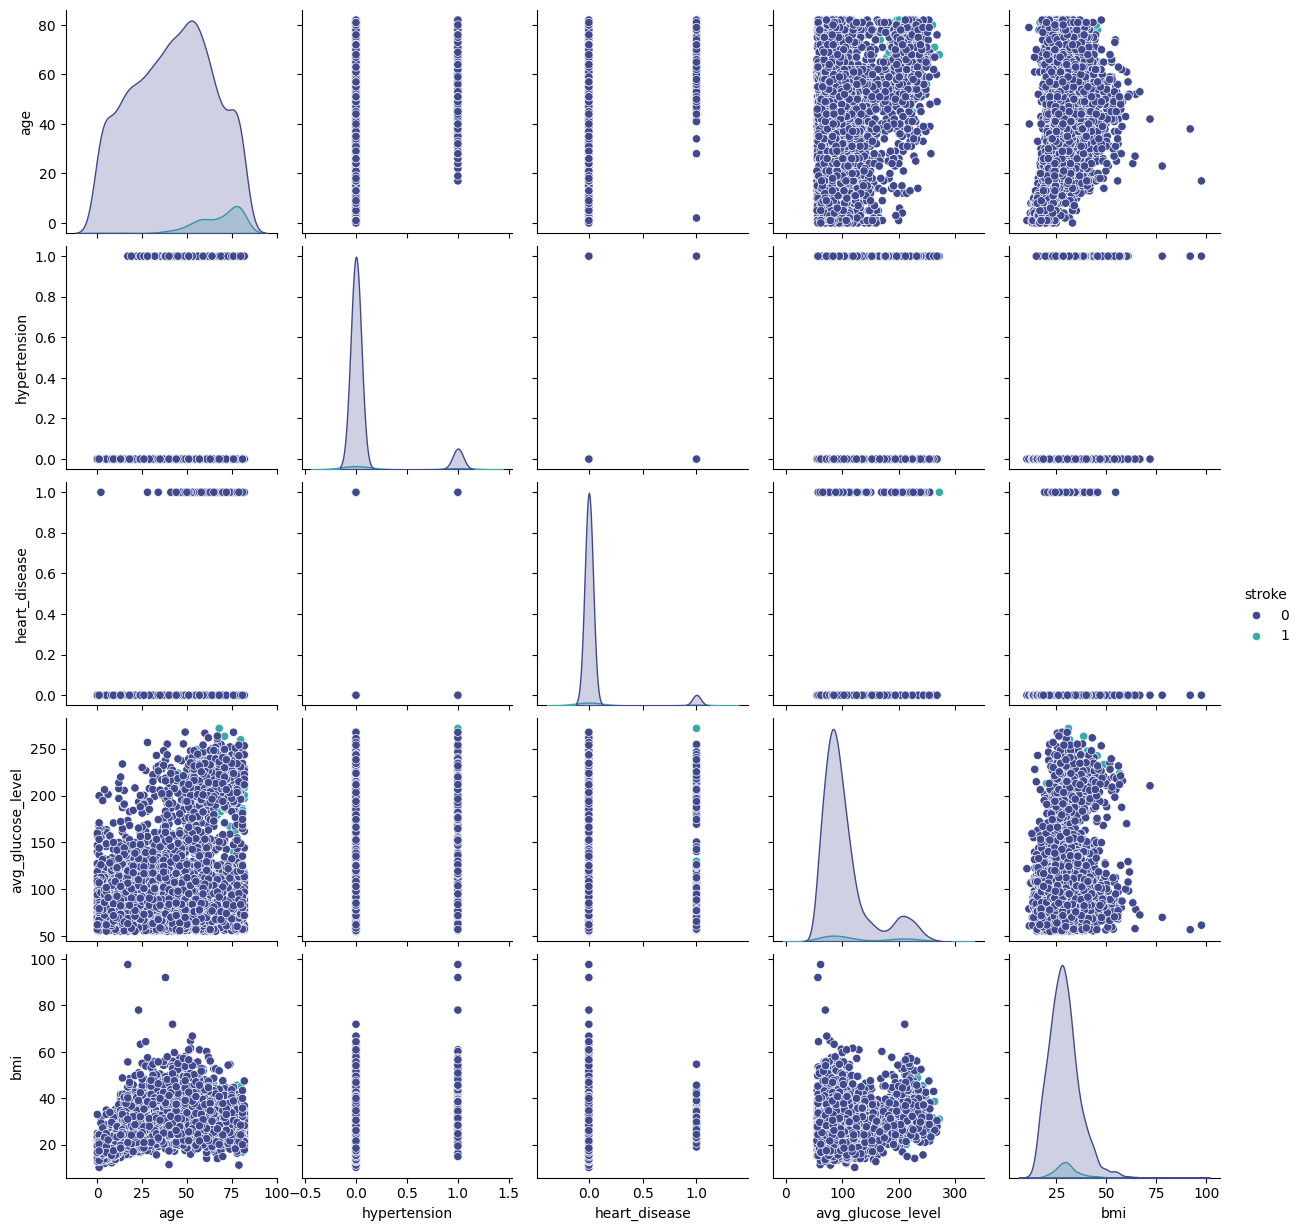

In [11]:
plt.figure(figsize=(10,6))
sns.pairplot(data,hue='stroke',palette='mako')

## Numerical Features Distributions

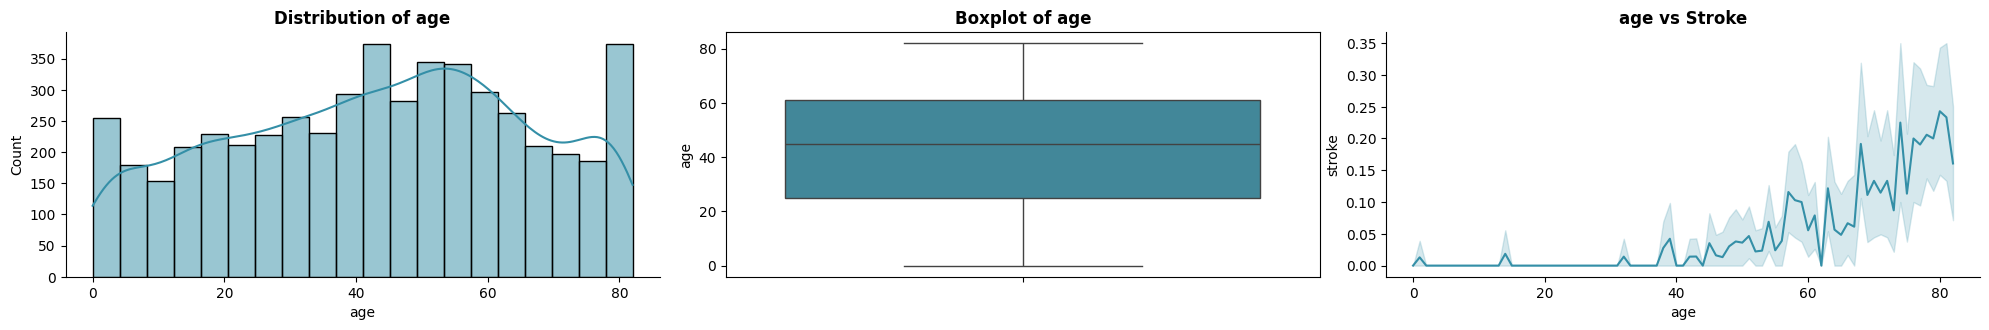

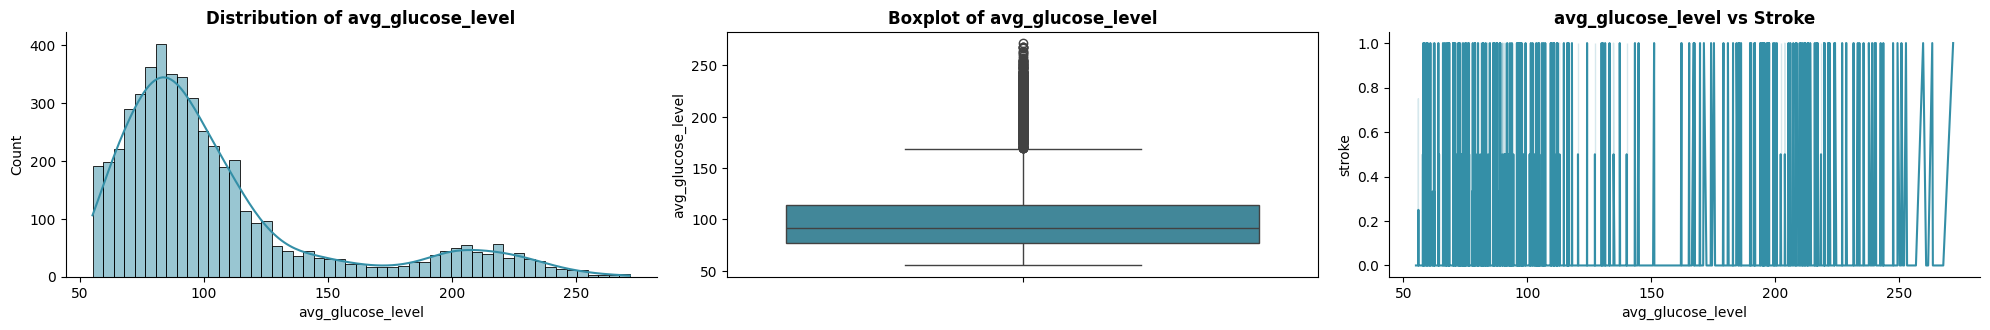

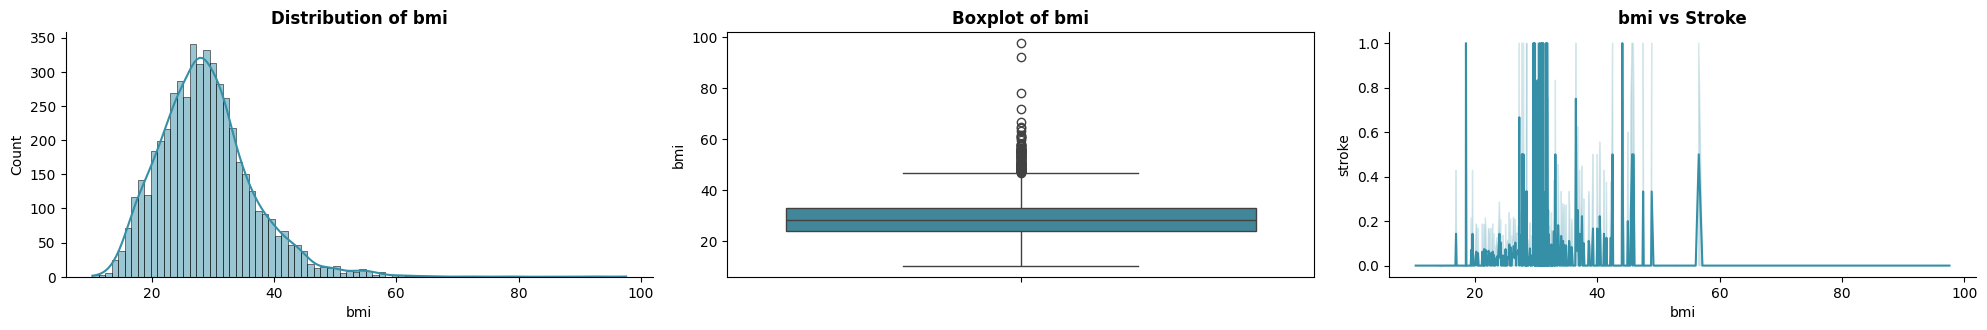

In [12]:
palette_color = sns.color_palette("mako")[3]

for i in numerical_features:
    fig = plt.figure(figsize=(20,6))

    # Histogram
    v = plt.subplot(2,3,1)
    sns.histplot(data=data, x=i, kde=True, color=palette_color)
    plt.title(f"Distribution of {i}", weight='bold')
    for side in ["top","right"]:
        v.spines[side].set_visible(False)

    # Boxplot
    b = plt.subplot(2,3,2)
    sns.boxplot(y=data[i], color=palette_color)
    plt.ylabel(i)
    plt.title(f"Boxplot of {i}", weight='bold')

    # Lineplot
    l = plt.subplot(2,3,3)
    sns.lineplot(data=data, x=i, y="stroke", color=palette_color)
    for side in ["top","right"]:
        l.spines[side].set_visible(False)
    plt.title(f"{i} vs Stroke", weight='bold')

    plt.tight_layout()
    plt.show()


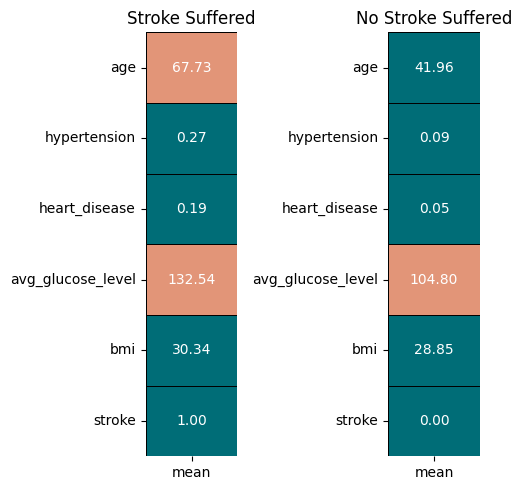

In [20]:
stroke = data[data['stroke'] == 1].describe().T
no_stroke = data[data['stroke'] == 0].describe().T

colors = ['#006D77', '#E29578']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Stroke Suffered');

plt.subplot(1,2,2)
sns.heatmap(no_stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Stroke Suffered');

fig.tight_layout()


## Categorical Features Distributions

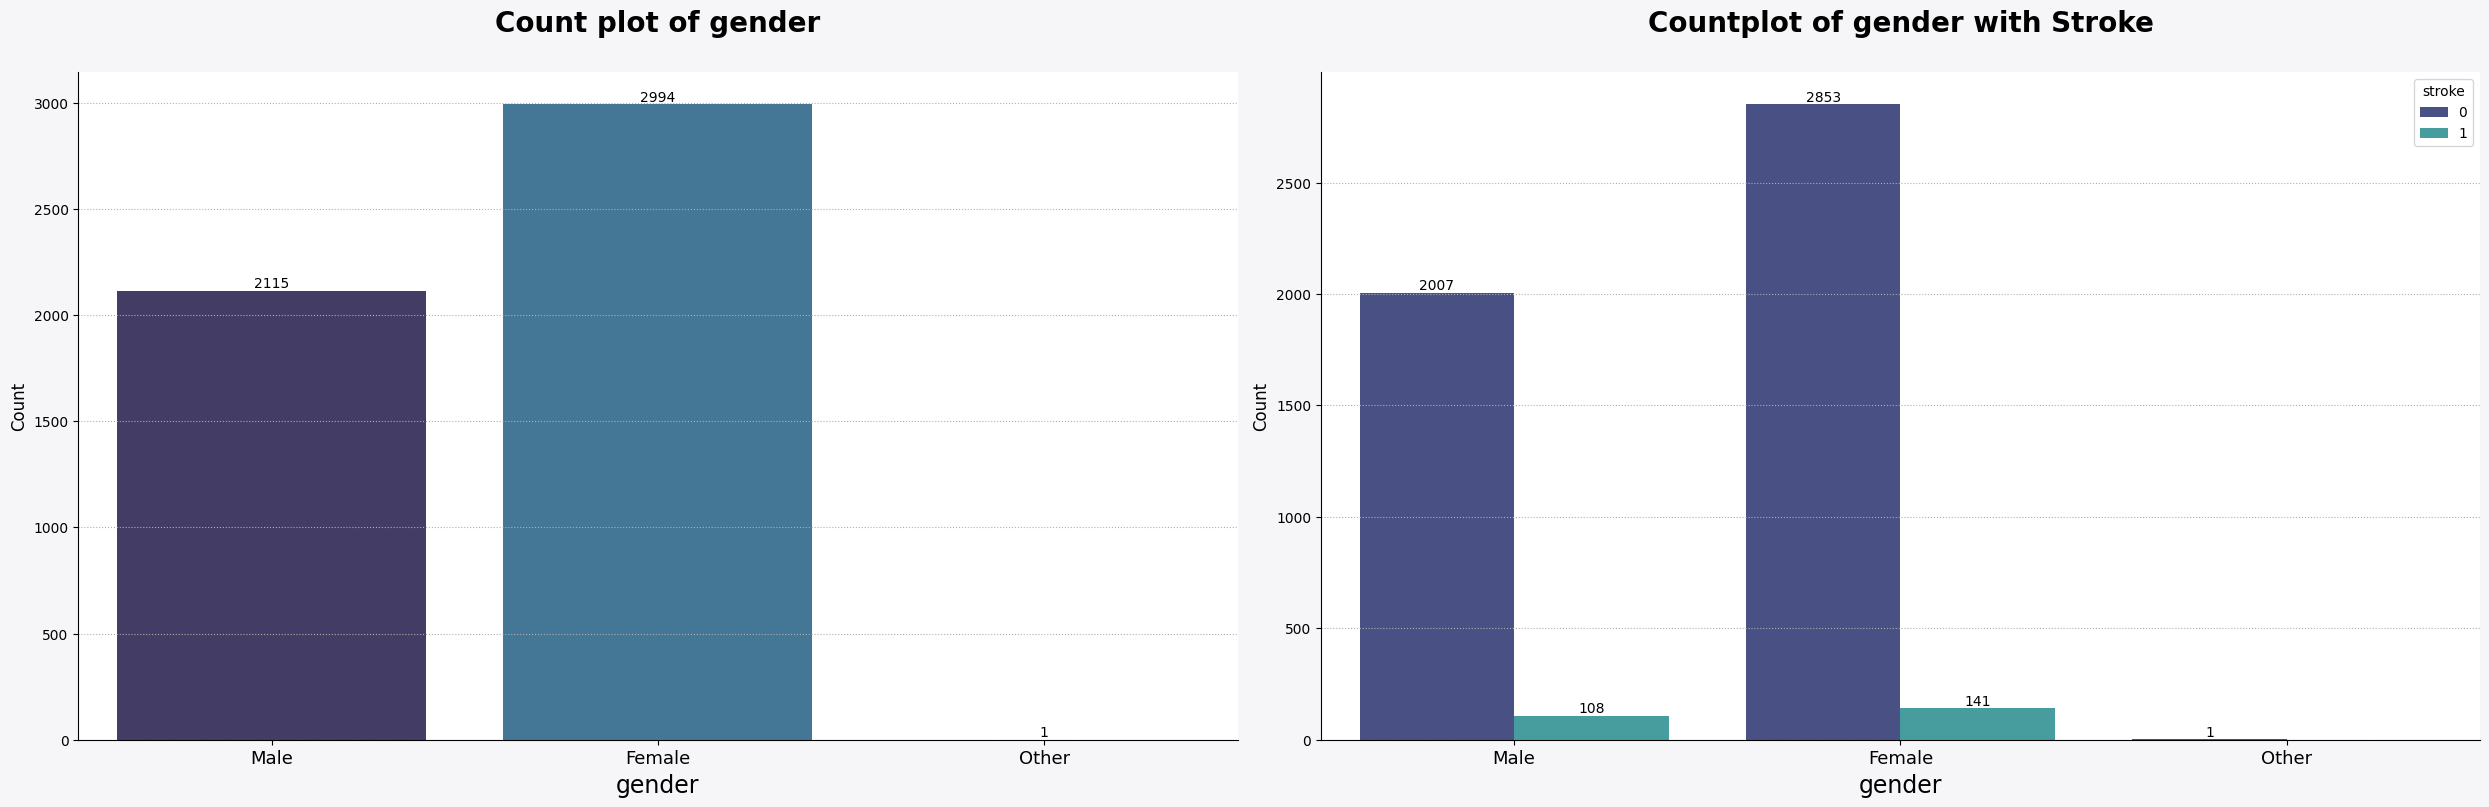

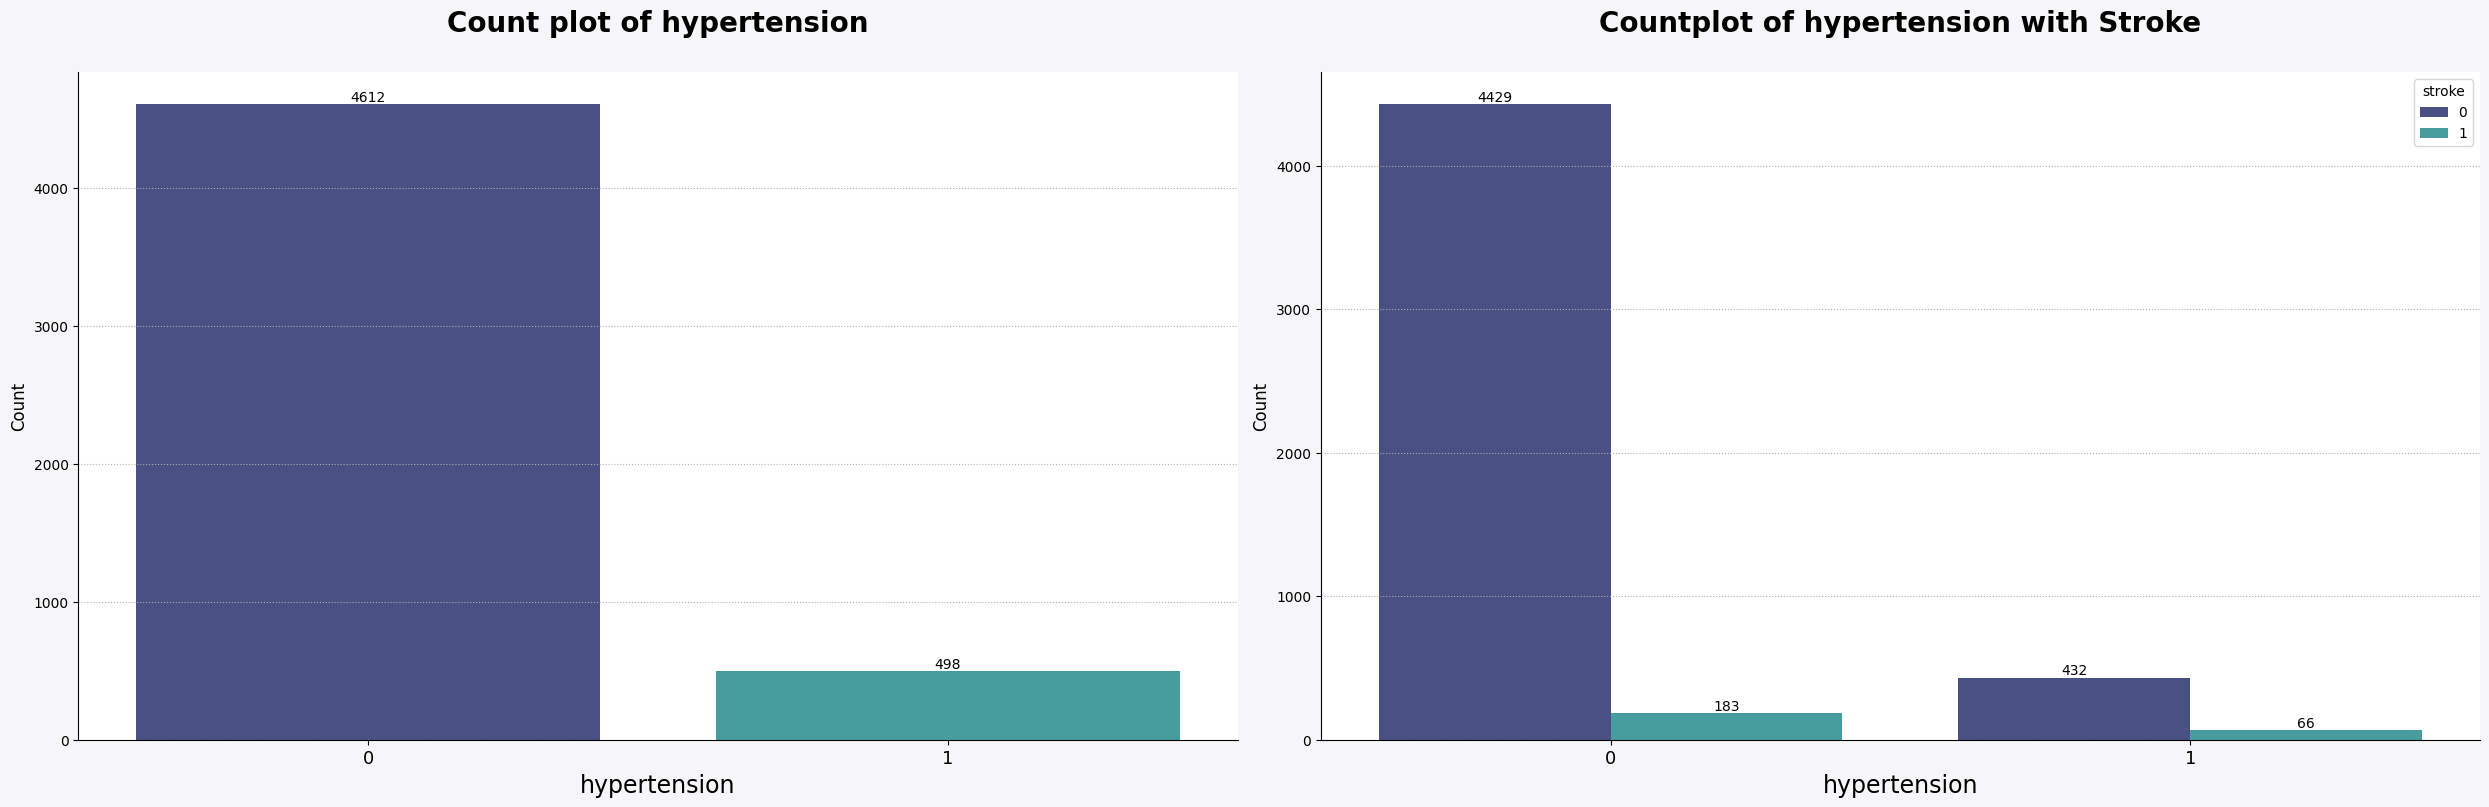

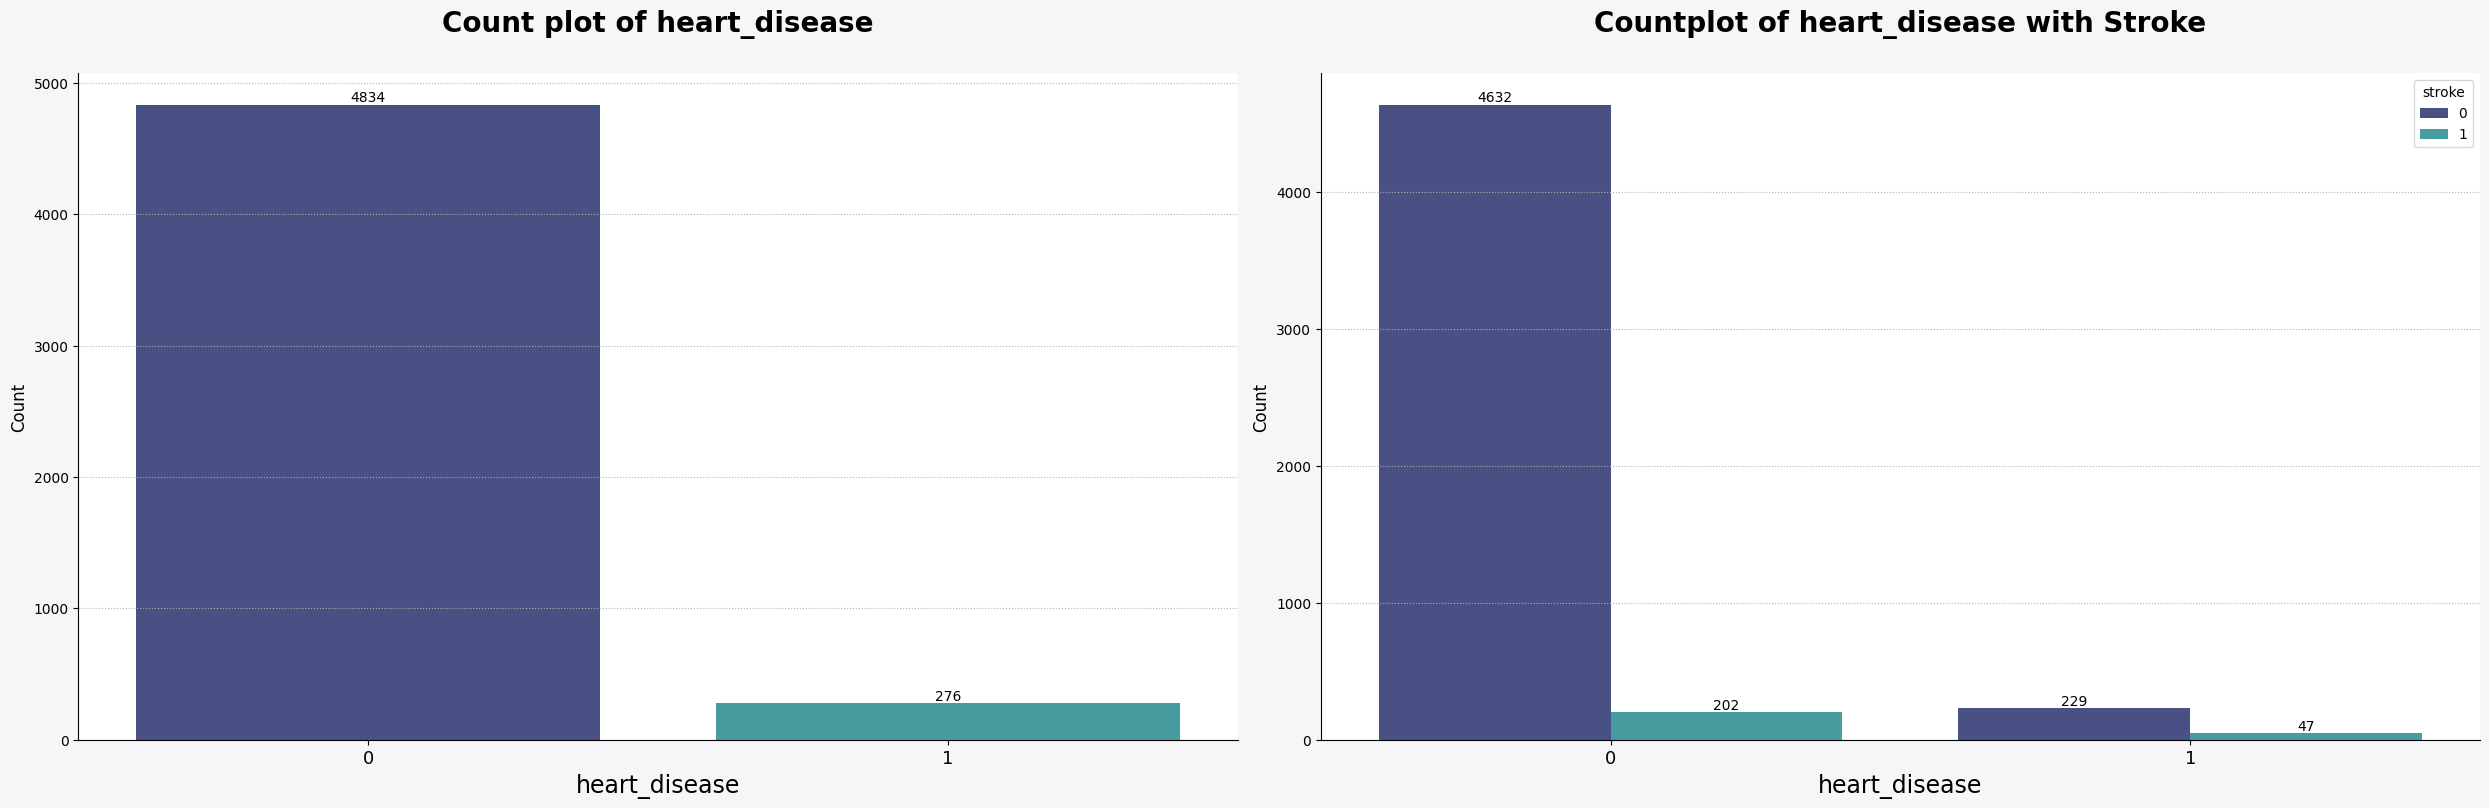

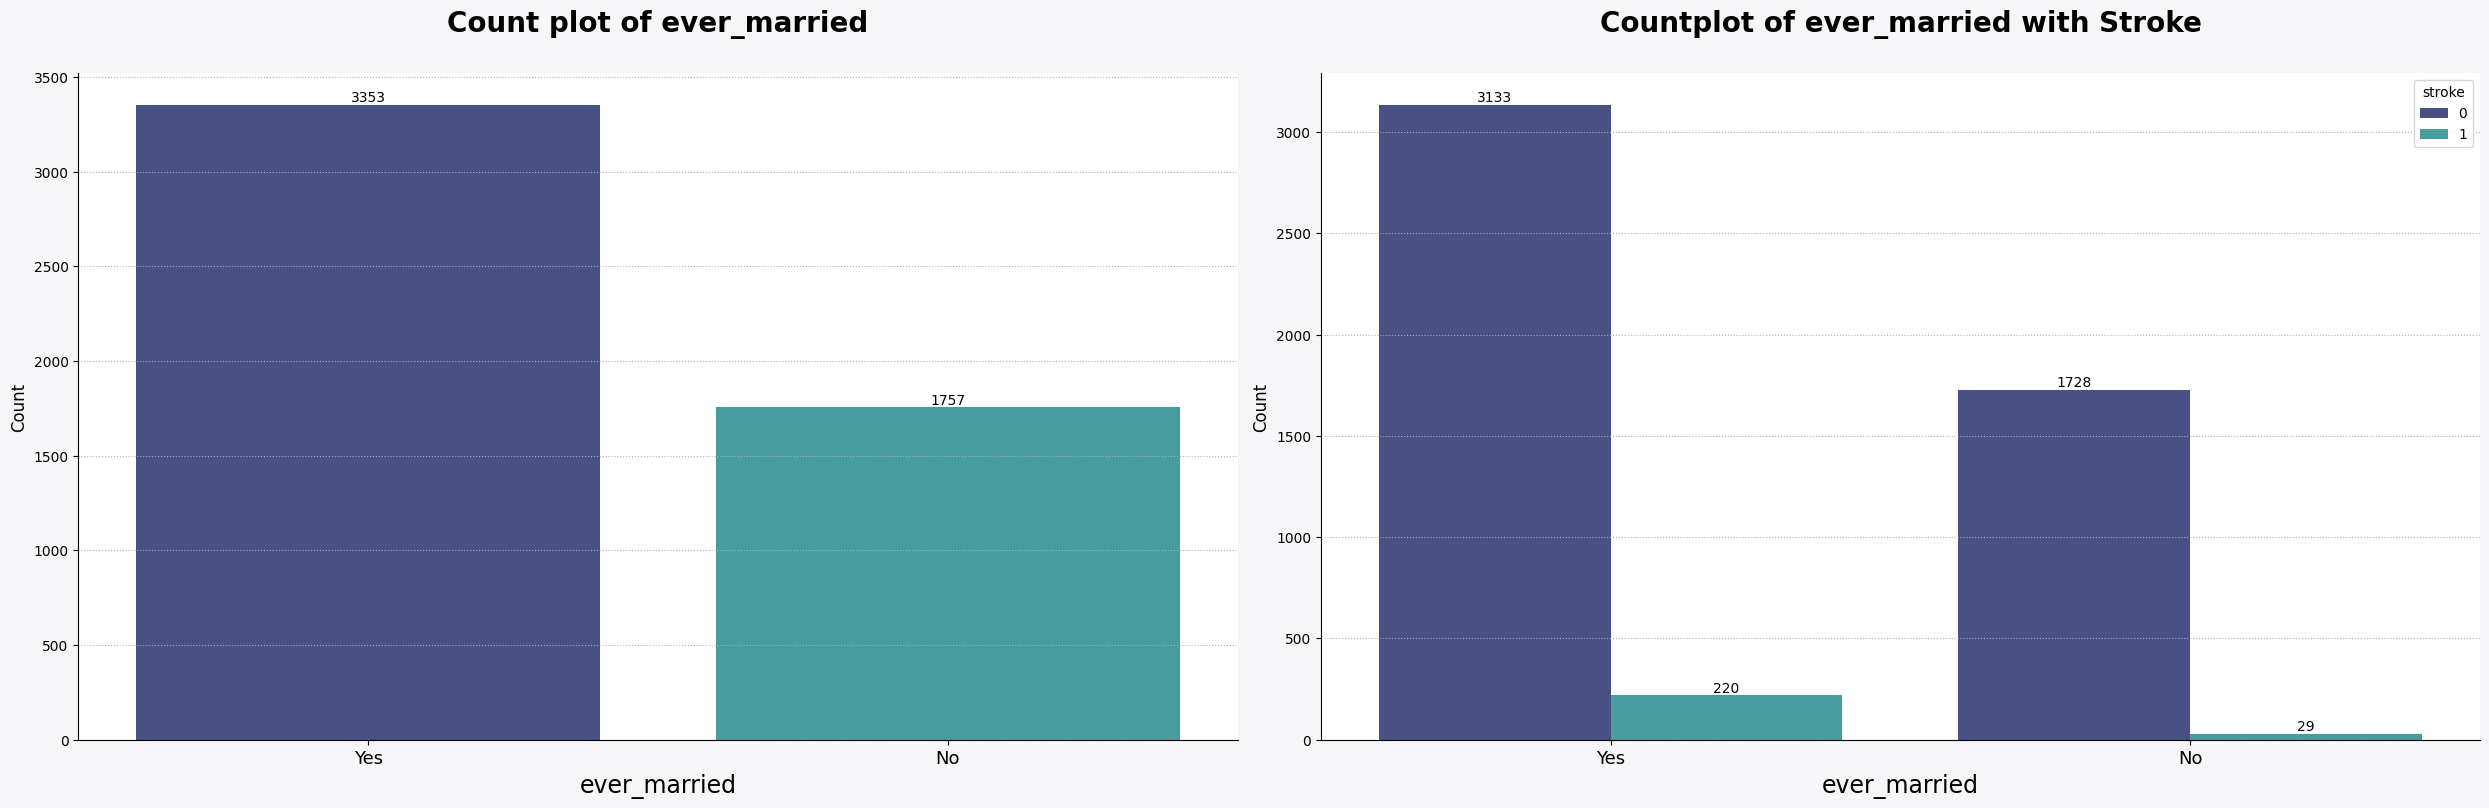

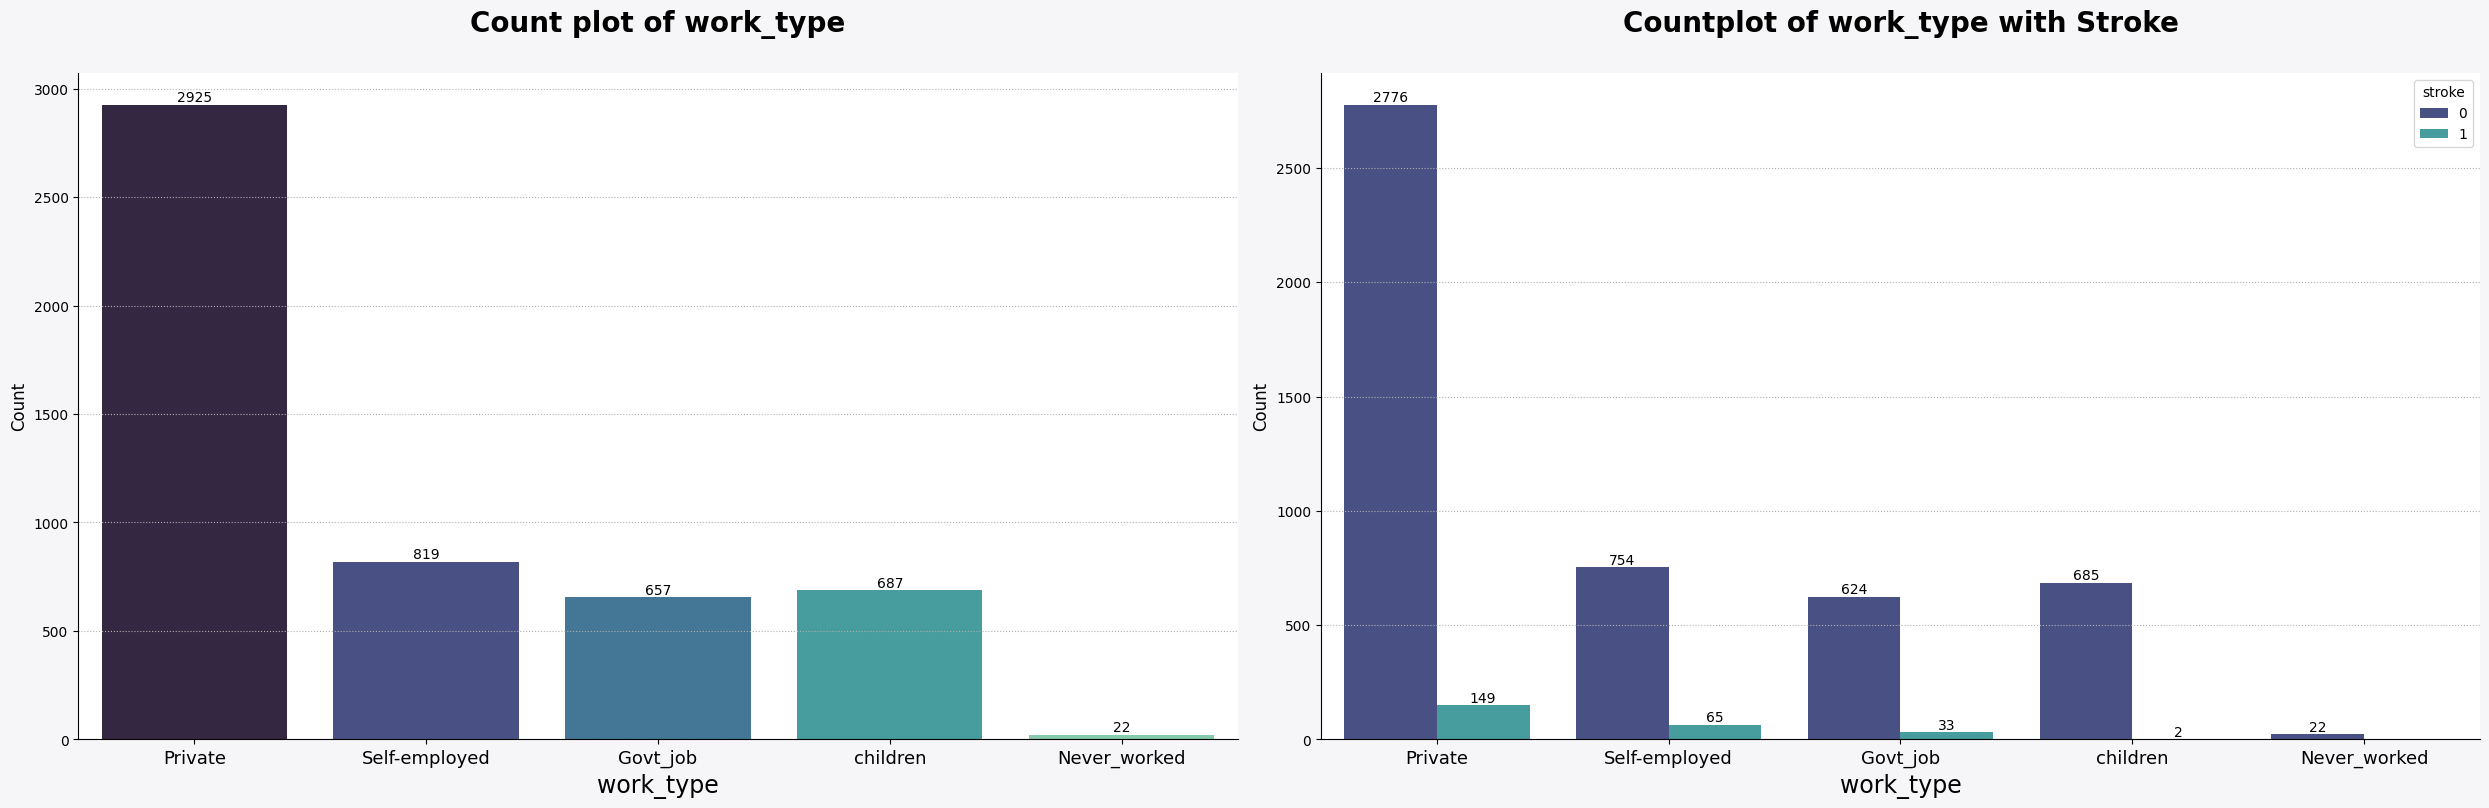

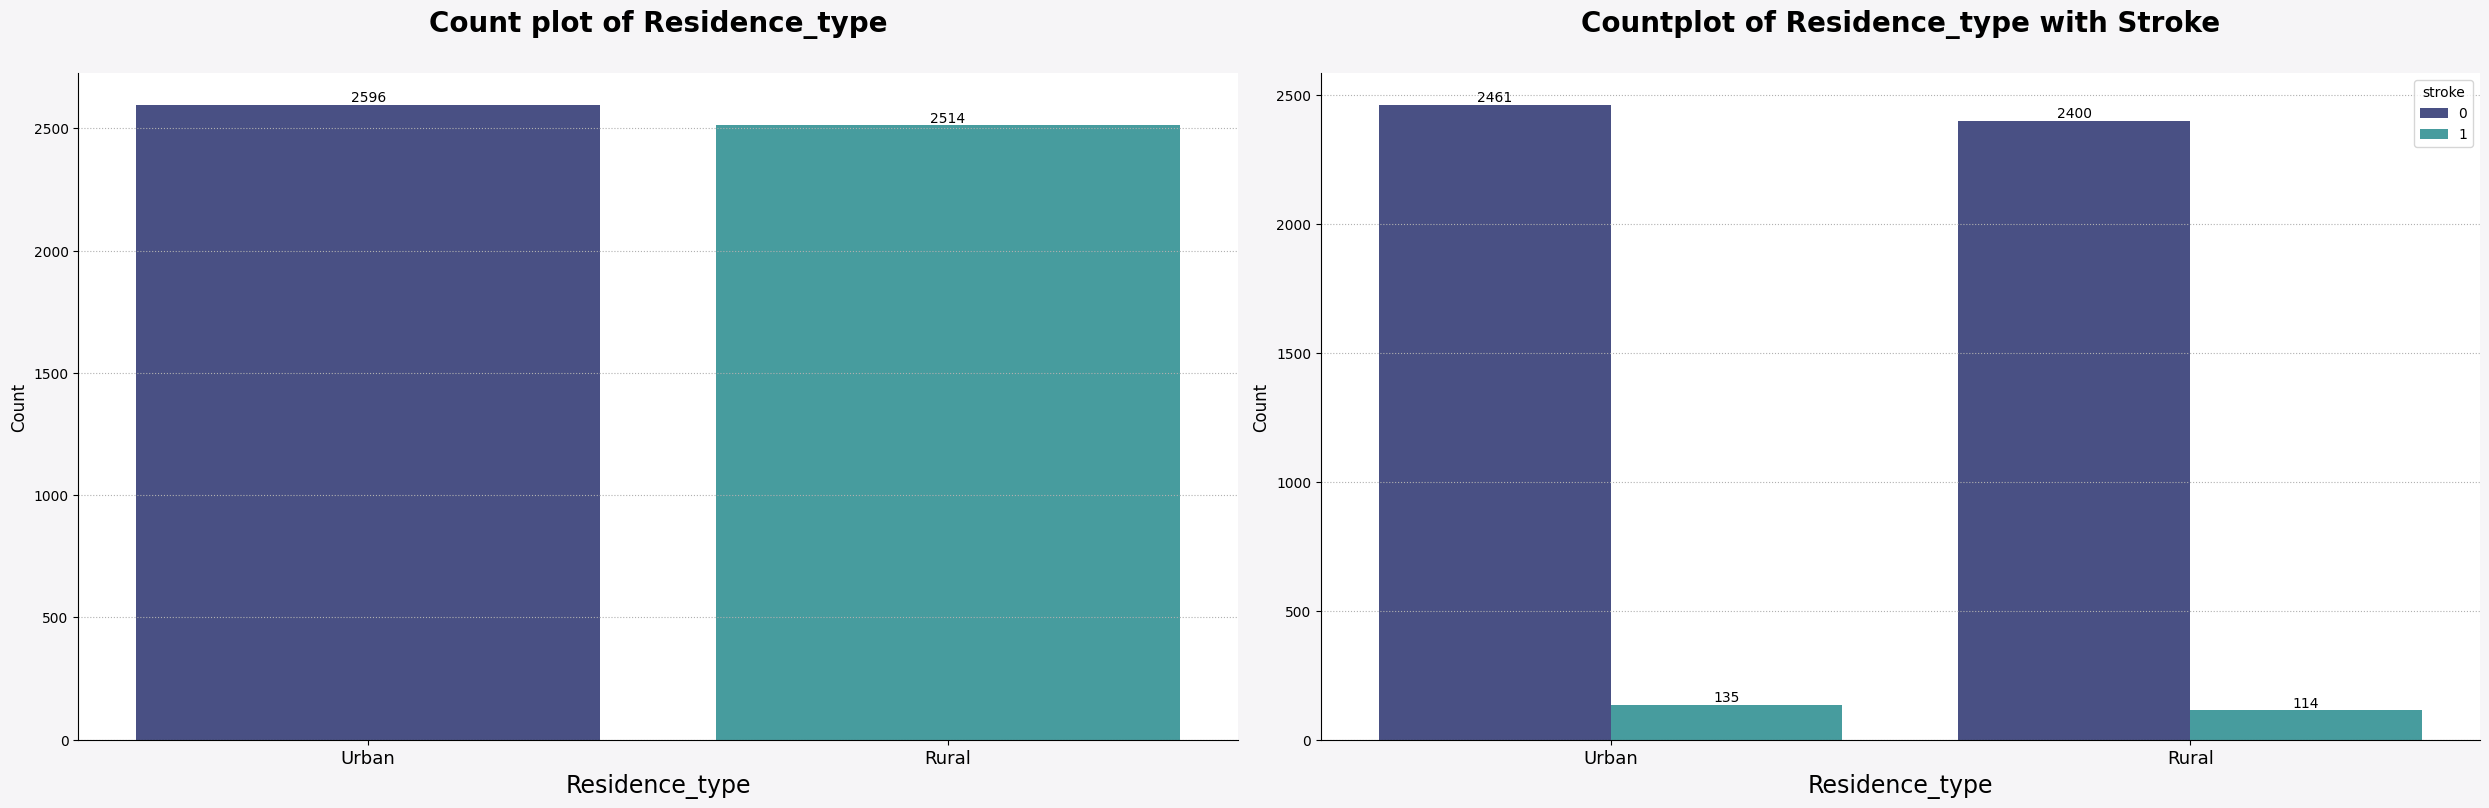

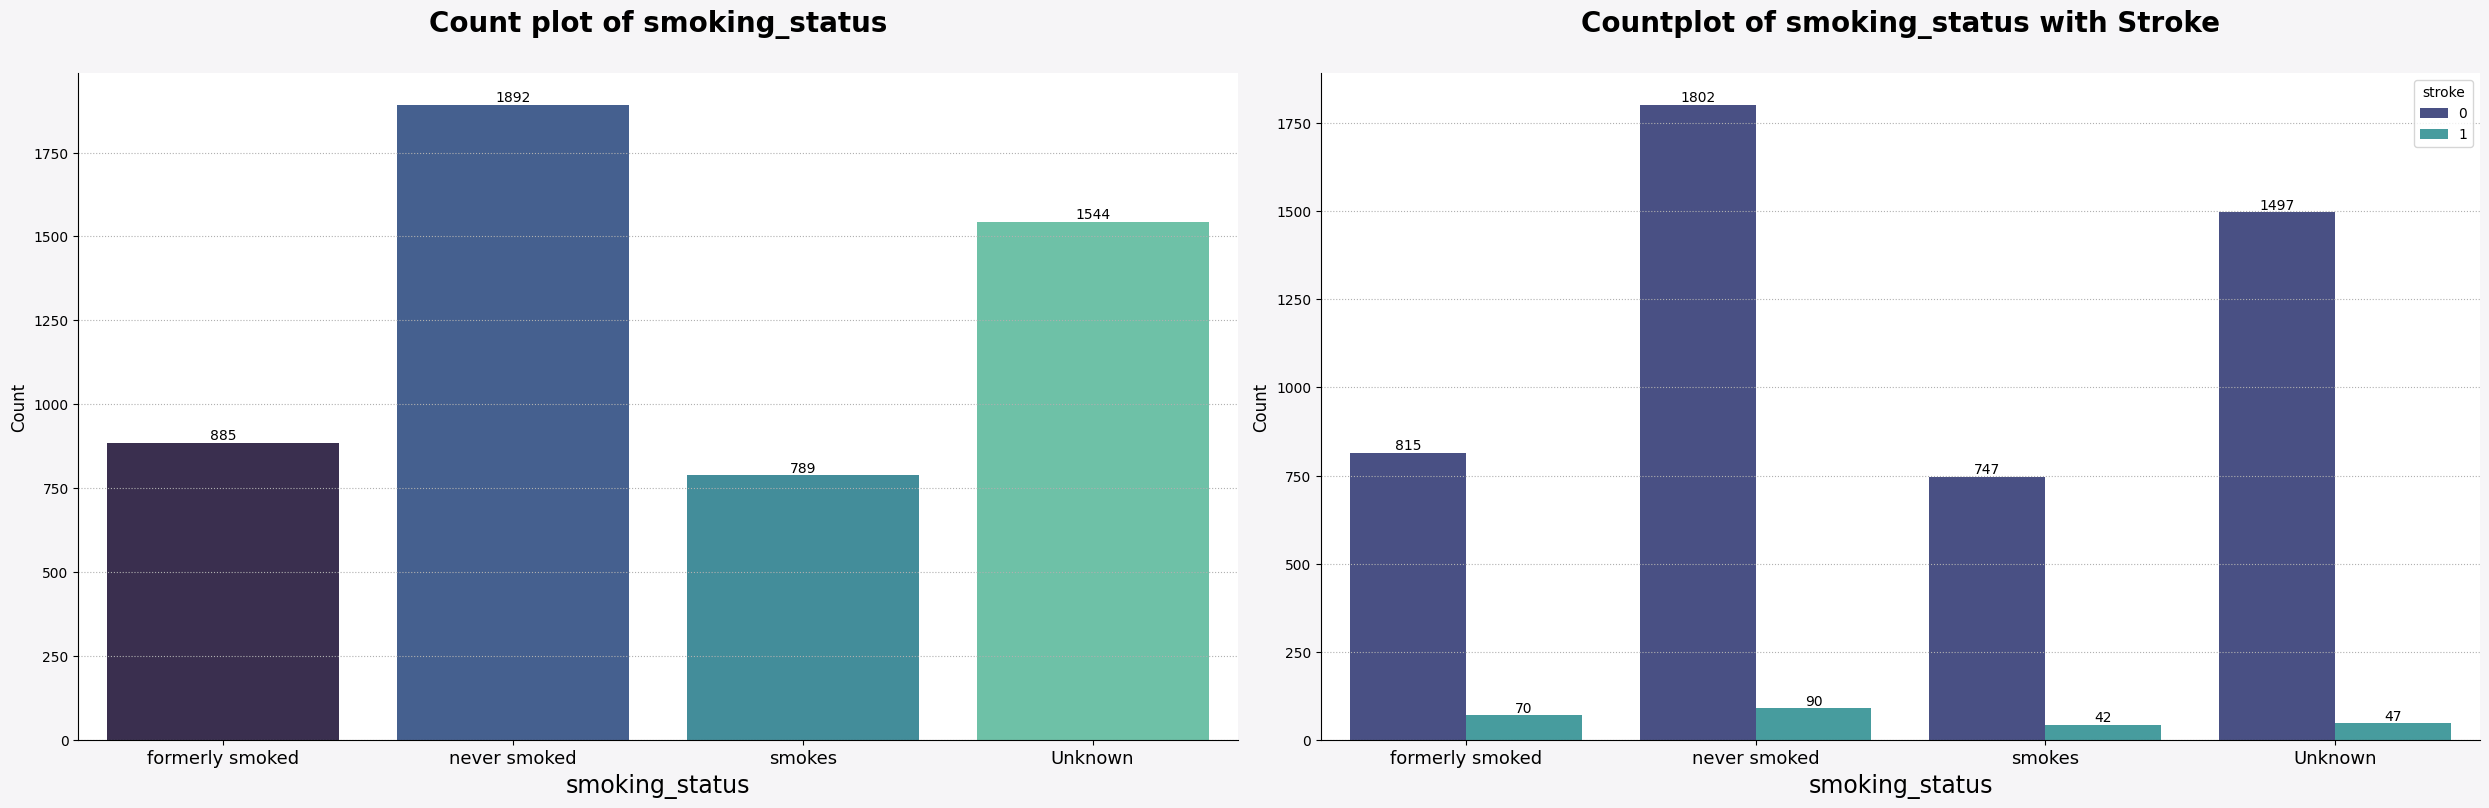

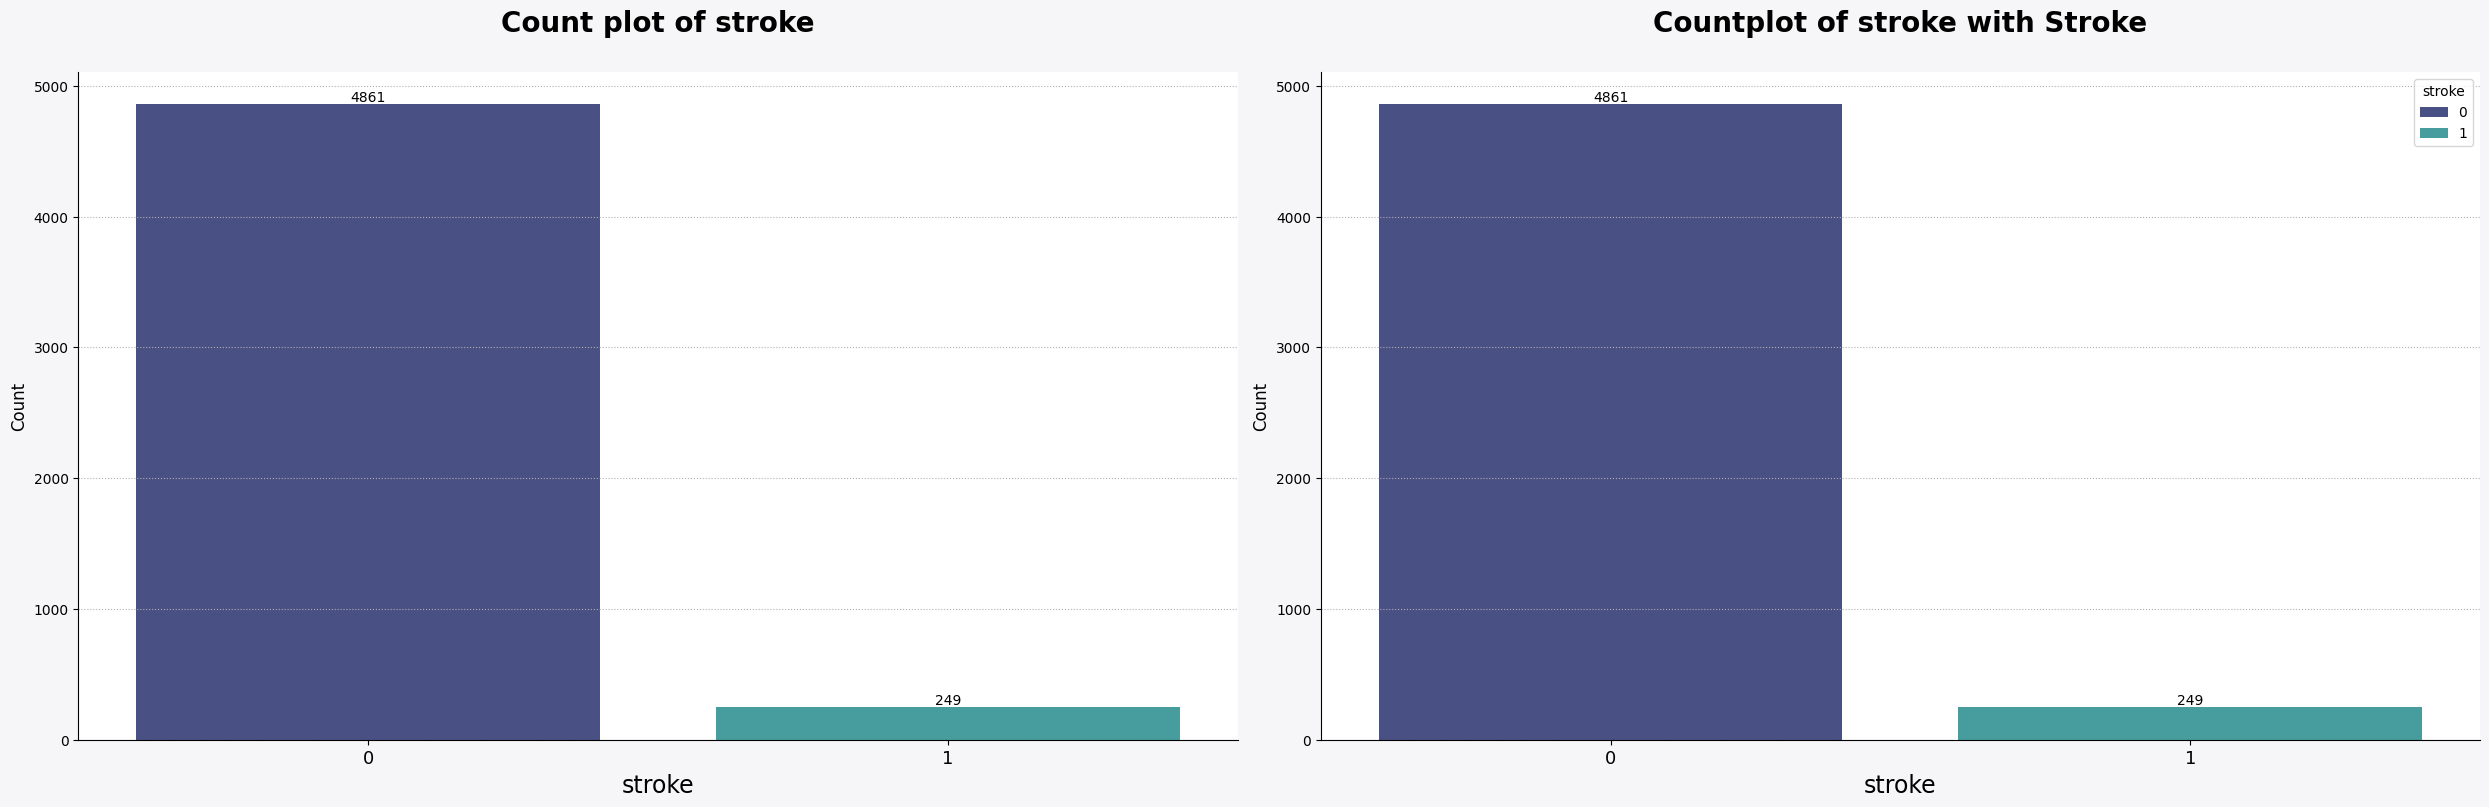

In [14]:
# mako_palette = sns.color_palette("mako")

for i in categorical_features:
    fig = plt.figure(figsize=(25,15))
    fig.patch.set_facecolor("#f6f5f7")

    # Countplot for the categorical feature
    xx = plt.subplot(2,2,1)
    # xx.set_facecolor("#f6f5f7")
    x = sns.countplot(data=data, x=i, palette='mako')
    for container in x.containers:
        x.bar_label(container)
    plt.xticks(fontsize=13)
    plt.xlabel(i, fontsize=17)
    plt.ylabel("Count", fontsize=12)
    plt.title(f"Count plot of {i}\n", fontsize=20, weight="bold")
    for side in ["top","right"]:
        xx.spines[side].set_visible(False)
    xx.grid(linestyle=':', axis='y')

    # Countplot with hue="stroke"
    vv = plt.subplot(2,2,2)
    # vv.set_facecolor("#f6f5f7")
    v = sns.countplot(data=data, x=i, hue="stroke", palette='mako')
    for container in v.containers:
        v.bar_label(container)
    plt.xticks(fontsize=13)
    plt.xlabel(i, fontsize=17)
    plt.ylabel("Count", fontsize=12)
    plt.title(f"Countplot of {i} with Stroke\n", fontsize=20, weight="bold")
    for side in ["top","right"]:
        vv.spines[side].set_visible(False)
    vv.grid(linestyle=':', axis='y')

    plt.tight_layout()
    plt.show()

#### Gender
    Male compare to female are more likelyto get stroke, but difference between female and male is very small.
#### Hypertension
    Person with hypertension are almost 3.3 time more likely to get stroke than the ones who don't have hypertension.

#### Heart Disease
    Person with heart diease are 4.07 times more likely to get stroke than the ones who don't have heart disease.
#### Marriage
    Person who is married(or married before) are 5.7 times more likely to get stroke than the ones who don't have marriage history.   
  > ده مش هيغير نظرتنا عن الجواز طبعاً, فاللهم يسر لنا زواجنا
#### Work
    - If you have never worked, you will not die by stroke !!! Just kidding.
    - Self employed person has more probability to get stroke than other work type.
    - Person with private job and goverment job almost has same probability to get stroke.
#### Residence Area
    As seen, there is not much difference between person residence type.
#### Smoking
    There are differeneces based on the smoking habits.
    - A formerly smoked person has a probability to get stroke 1.66 times more than person never smoked.
    - A person smokes has a a probability to get stroke 1.11 times more than person never smoked.



# Prepare Categorical Features for Encoding

In [22]:
df1 = data.copy()

In [21]:
categorical_cols_to_examine = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_cols_to_examine:
    print(f"\n--- {col} ---")
    print(data[col].value_counts())



--- gender ---
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

--- ever_married ---
ever_married
Yes    3353
No     1757
Name: count, dtype: int64

--- work_type ---
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

--- Residence_type ---
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

--- smoking_status ---
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


In [23]:
data['gender'] = data['gender'].replace('Other', data['gender'].mode()[0])

# Label Encoding for binary features
le = LabelEncoder()
data['ever_married'] = le.fit_transform(data['ever_married'])
data['Residence_type'] = le.fit_transform(data['Residence_type'])

# One-Hot Encoding for multi-category features
data = pd.get_dummies(data, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)

print("Categorical features encoded successfully.")
print(data.head())

Categorical features encoded successfully.
   age  hypertension  heart_disease  ever_married  Residence_type  \
0   67             0              1             1               1   
1   61             0              0             1               0   
2   80             0              1             1               0   
3   49             0              0             1               1   
4   79             1              0             1               0   

   avg_glucose_level   bmi  stroke  gender_Male  work_type_Never_worked  \
0             228.69 36.60       1         True                   False   
1             202.21 29.88       1        False                   False   
2             105.92 32.50       1         True                   False   
3             171.23 34.40       1        False                   False   
4             174.12 24.00       1        False                   False   

   work_type_Private  work_type_Self-employed  work_type_children  \
0               True  

# Relation between features against target

## Corrleation Matrix

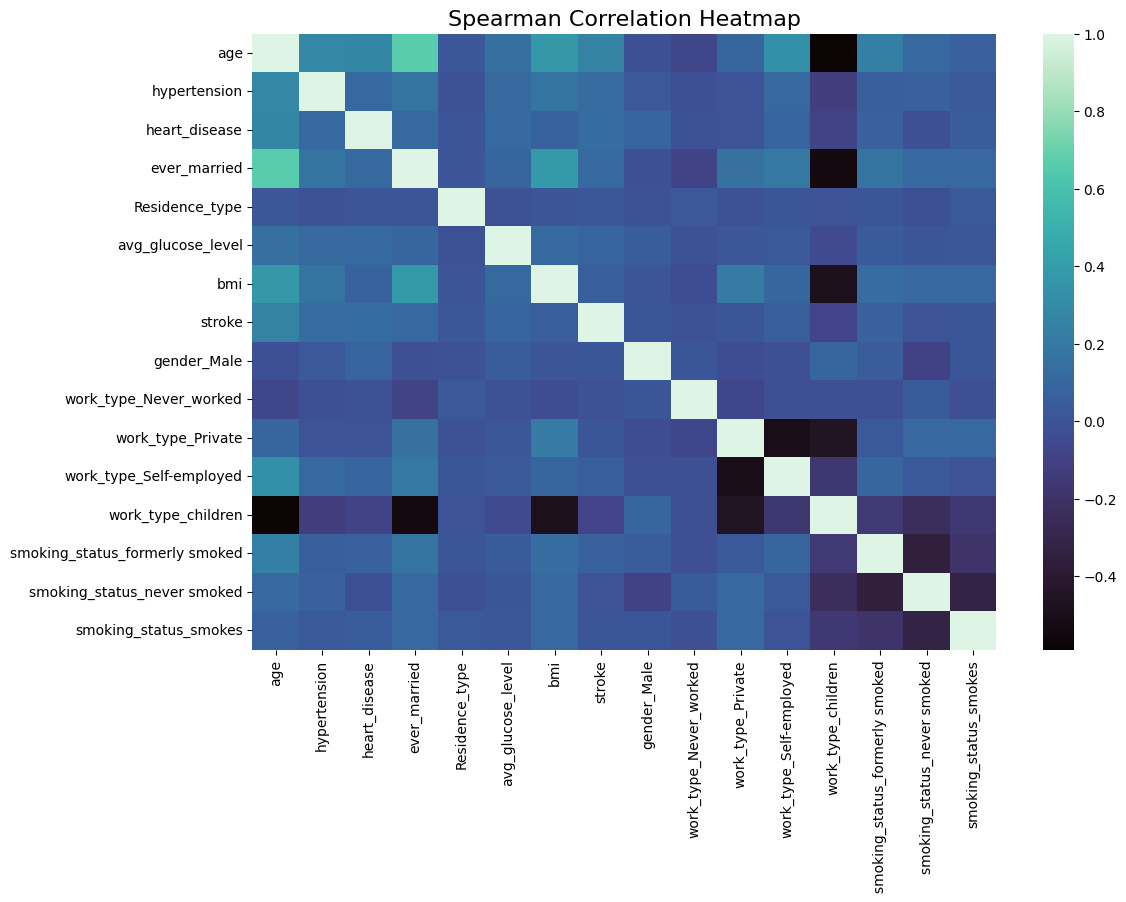

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(method='spearman'), cmap='mako', annot=False)
plt.title("Spearman Correlation Heatmap", fontsize=16)
plt.show()

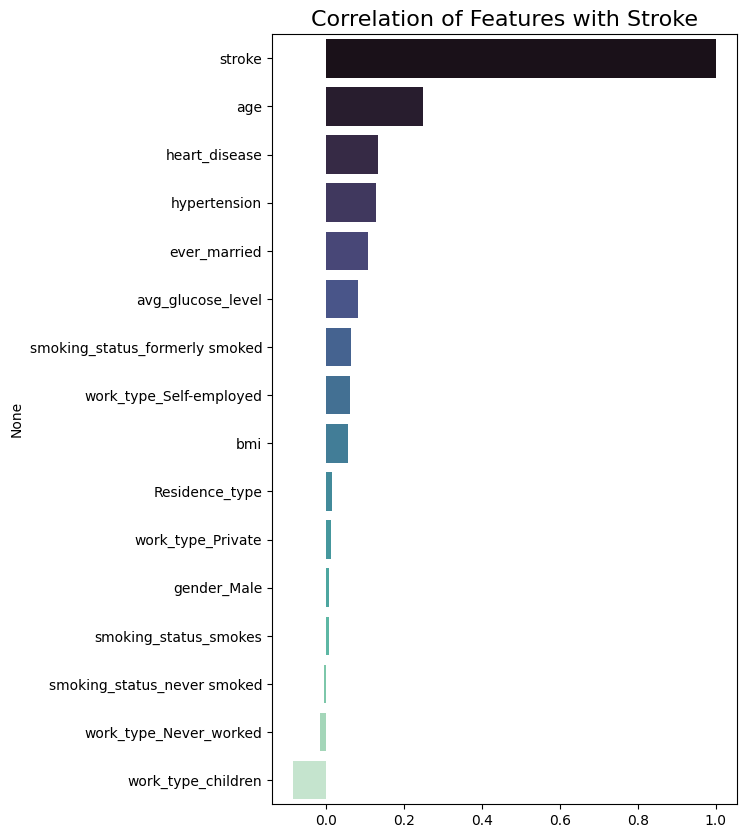

In [32]:
target_corr = data.corr(method='spearman')['stroke'].sort_values(ascending=False)

plt.figure(figsize=(6,10))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='mako')
plt.title("Correlation of Features with Stroke", fontsize=16)
plt.show()

### Why we use spearman correlation instead of pearson (default) ?
**Pearson Correlation**

* Measures linear relationships between two continuous variables
* Uses the actual values of the data
* Assumes the relationship is straight-line (linear)
* Ranges from -1 to +1
* Sensitive to outliers

**Spearman Correlation**

* Measures monotonic relationships (consistent direction, but not necessarily linear)
* Uses the ranks of the data instead of actual values
* Can detect non-linear relationships as long as they're monotonic (always increasing or always decreasing)
* Also ranges from -1 to +1
* More robust to outliers

In [24]:
X = data.drop('stroke', axis=1)
y = data['stroke']

print("Features (X) and target (y) separated.")
print("X shape:", X.shape)
print("y shape:", y.shape)

Features (X) and target (y) separated.
X shape: (5110, 15)
y shape: (5110,)


# Normalizing the Numerical Features